# Detect and resolve biases in Artificial Intelligence (re:Invent 2022)

*This notebook will show some insights you can create on datasets and models for a conference at re:Invent 2022 (Las Vegas). The goal is to show how we can spot biases at 3 different levels during a data science project.*

## Context

### Heart Diseases

Heart disease is the leading cause of death worldwide, with 16% of deaths:

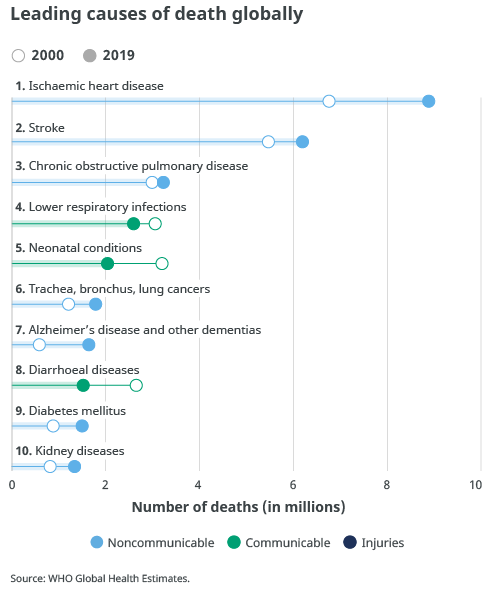

*(Source: https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death)*

A large proportion of deaths due to heart disease could be avoided with early diagnosis and appropriate treatment. But not everyone has access to medical care.

Proposing an application that would define people at risk to increase their chance of diagnosis / treatment could save hundreds of thousands of lives each year.

### Heart Disease Dataset

The dataset used is "Personal Key Indicators of Heart Disease", available on the Kaggle website: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

Dating from 2020, it contains the result of a CDC survey of 400,000 Americans. The main risk factors for heart disease are available in this dataset: obesity, smoking or drinking alcohol, lack of physical effort...

The dataset available on Kaggle is a prepared and cleaned version of the original dataset, containing 18 features (including the presence of heart disease) for 319,795 individuals.

### Biases and how to spot them

Bias is an inclination or prejudice for or against one person or group, especially in a way considered to be unfair! 

This can lead to discrimination for a given population, generally a minority.

Finding the biases as early as possible in a Machine Learning project is therefore necessary, so as not to add injustice to a world that is already far from perfect.

In data science, one of the most used methodologies is CRISP-DM (CRoss Industry Standard Process for Data Mining). Every project has 6 phases:

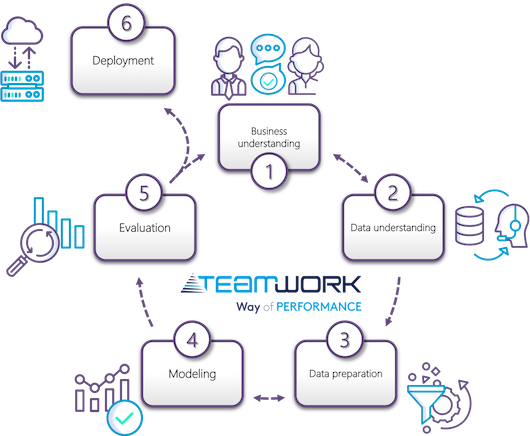

There are 3 crucial phases in this methodology where we can detect these biases and, potentially, remove them:

1. *Business Understanding:* the goal is to understand the context of the project, the available resources, the success criteria. **We can discover biases at this stage by looking at how the data was created and selected.**

2. *Data Understanding:* this phase consists of analyzing the data to detect potential quality problems. **It is also possible to detect biases through the analysis of distributions.**

3. *Data Preparation:* in this phase the data is prepared following the recommendations of the previous phase, in order to be used in the next phase.

4. *Modeling:* it is in this phase that the models are created and optimized. Performance metrics are also analyzed to keep only the models that seem the most relevant.

5. *Evaluation:* the selected models are analyzed in more depth and compared to the needs of the client who will be able to validate (or not) these. **In this phase, it is possible to use the explainable ai to detect biases before going into production.**

6. *Deployment:* If the models are considered good enough, they are deployed. This phase therefore corresponds to all the stages of ML Ops, with the creation of APIs, monitoring, retraining, ...

## Business Understanding


### Potential biases from source

From Kaggle:

"Originally, the dataset come from the CDC [...] which conducts annual **telephone surveys** to gather data on the health status of U.S. residents. [...] BRFSS completes more than 400,000 adult interviews each year [...] The most recent dataset (as of February 15, 2022) includes data from 2020. It consists of 401,958 rows and 279 columns. [...] so I decided to **select the most relevant variables from it and do some cleaning** [...]"

**Potential biases:**

* Phone survey: only people with a phone can answer. They must also have the time to respond (mostly retired or unemployed people) and want to answer such surveys.

* This is not medical data from a hospital or clinic, but a survey: they may lie and/or not have correct and reliable information.

* The dataset has been cleaned beforehand, but we do not know the preparations made: there may be a selection bias.

### Potential biases from data dictionary

|Feature|Description|Format|Unit|Comment|
|-|-|-|-|-|
|(index)|Unique ID|Integer||Only for pandas|
|HeartDisease|Target feature|Boolean (Yes/No)||Yes: coronary heart disease (CHD) or myocardial infarction (MI), No: not ill|
|BMI|Body Mass Index|<18.5: underweight; 18.5-25: normal; 25-30: overweight;30-35: obesity; >35: severe obesity|$\frac{kg}{m^{2}}$|Mass/(Height)2|
|Smoking|Have you smoked at least 100 cigarettes in your entire life?|Boolean (Yes/No)||Yes: more than 5 packs (100) in the entire life|
|AlcoholDrinking|Are you a heavy drinker??|Boolean (Yes/No)||For men: >14 drinks/w; women: >7 drinks/w|
|Stroke|(Ever told) (you had) a stroke?|Boolean (Yes/No)|||
|PhysicalHealth|Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0-30 days)|Integer (0-30)|Days|Better condition: lower number|
|MentalHealth|Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days)|Integer (0-30)|Days|Better condition: lower number|
|DiffWalking|Do you have serious difficulty walking or climbing stairs?|Boolean (Yes/No)|||
|Sex|Are you male or female?|String||"Female" or "Male" only|
|AgeCategory|Age categories|String|Years|13 categories: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80 or older -- 14 indicated in dataset information(?)|
|Race|Imputed race/ethnicity value|String||6 categories: White, Hispanic, Black, Asian, American Indian/Alaskan Native, Other|
|Diabetic|(Ever told) (you had) diabetes?|Boolean (Yes/No)|||
|PhysicalActivity|Adults who reported doing physical activity or exercise during the past 30 days other than their regular job|Boolean (Yes/No)|||
|GenHealth|Would you say that in general your health is|String||5 categories: Excellent, Very good, Good, Fair, Poor|
|SleepTime|On average, how many hours of sleep do you get in a 24-hour period?|Integer (0-24)|Hours||
|Asthma|(Ever told) (you had) asthma?|Boolean (Yes/No)|||
|KidneyDisease|Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?|Boolean (Yes/No)|||
|SkinCancer|(Ever told) (you had) skin cancer?|Boolean (Yes/No)|||

**Potential biases:**

* The BMI may clearly have been incorrectly estimated, either by lying about the weight or by miscalculation
* Smoking and AlcoholDrinking are created arbitrarily, and there is a high risk of lies too

## Data Understanding

There is two main ways to detect biases in datasets:

* univariate analysis: we study each feature individually
* bivariate analysis: we study each feature regarding another one.

### Code Imports & Dataset Loading

First, we have to import every necessary library:

In [1]:
# Imports zone for the whole notebook

# Classical libraries
import pandas as pd
import numpy as np

# For graphics
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# For data preparation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing

# For modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# For analysis
from sklearn import tree
from lime.lime_tabular import LimeTabularExplainer

And then the dataset, downloaded as a CSV file from Kaggle. Just to be sure that everything is correct, print the shape of the DataFrame (319,795 rows and 18 features) and the first rows.

In [2]:
# Loading the dataset
df = pd.read_csv('data/heart_2020_cleaned.csv')
print(df.shape)
df.head(5)

(319795, 18)


HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

### Dataset splitting

It is MANDATORY to split the whole data between the train and test datasets, to avoid:
* **Data Leakage:** inadvertent transmission of information between train and test dataset, leading to biases in the models
* **Data Snooping:** it consists in choosing a model that corresponds to the test data, which (apparently) leads to better results but gives a distorted view of reality

Data leakage refers to the involuntary transmission of confidential data from a company to an external recipient.

**Train:** 80% of the dataset, selected randomly (we fix the random seed to be able to reproduce the entire code with the same results) => 255,836 rows

**Test:** remaining 20% of the dataset => 63,959 rows

In [3]:
# Train / Test split via Pandas
df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index)
print(df_train.shape, df_test.shape)

(255836, 18) (63959, 18)


### Univariate analysis

With univariate analysis, we can focus on each feature individually.

A bias will often result in a population that is unbalanced or different from the uniform or Gaussian distributions. In addition, outliers can indicate biases via inconsistent values.

**Be careful:** some "biases" are in fact just very interesting insights. No tool can tell you if it's a real bias or a very interesting fact, and you will have to find it yourself...

#### For categorical features

Categorical features are, in the "perfect" cases:

* well-balanced between each modality
* no "extra" modalities (i.e. modality that are not what you can expect)
* no missing values.

**HeartDisease** is the target feature. It's very important to study it.

In [4]:
# Heart Disease statistical description
df_train['HeartDisease'].describe()

count     255836
unique         2
top           No
freq      233923
Name: HeartDisease, dtype: object

In [5]:
# Missing values
df_train['HeartDisease'].isna().sum()

0

<AxesSubplot:>

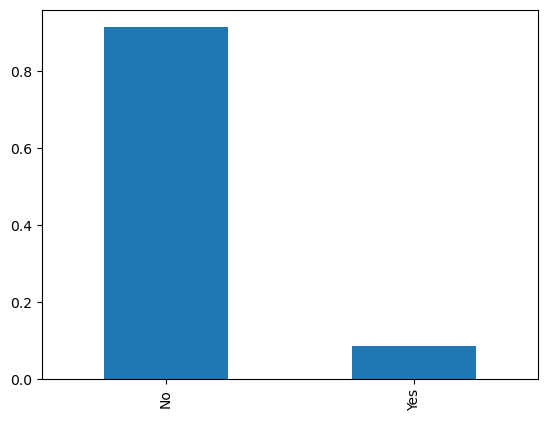

In [6]:
# Bar plot
df_train['HeartDisease'].value_counts(normalize=True).plot(kind="bar")

*Conclusion:* 

HeartDisease has only 2 modalities and no missing values but is very unbalanced so models may have difficulties to predict high risk patients. Some ways to deal with it:

* choose the right metric for your model (not the accuracy, but maybe the F1 score or the recall in this case)
* find more data for the "Yes" class
* oversampling: each "Yes" will have more weight in the model
* subsampling: some random "No" will be removed.

We must do the same for each feature. Here we study **Diabetic**:

In [7]:
# Diabetic description
df_train['Diabetic'].describe()

count     255836
unique         4
top           No
freq      215802
Name: Diabetic, dtype: object

<AxesSubplot:ylabel='Diabetic'>

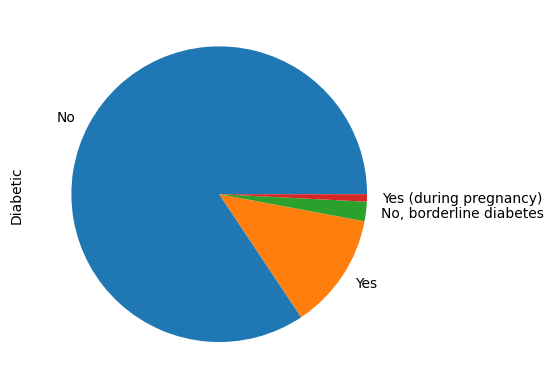

In [8]:
# Pie chart
df_train['Diabetic'].value_counts(normalize=True).plot(kind="pie")

*Conclusion:*

Here, we have a modality problem: there are 4 of them, but we expect only 2 (Yes/No). The 2 other modalities are very unbalanced ("No, borderline diabetes" and "Yes (during pregnancy)".

You should ask a cardiologist or diabetes specialist if these modalities can be combined with "Yes" or "No", so to have only 2 valid values.

With such unbalanced data, it is almost certain that the model will be biased for these 2 special cases.

**Race** 

In [9]:
# Race
df_train['Race'].describe()

count     255836
unique         6
top        White
freq      196081
Name: Race, dtype: object

<AxesSubplot:>

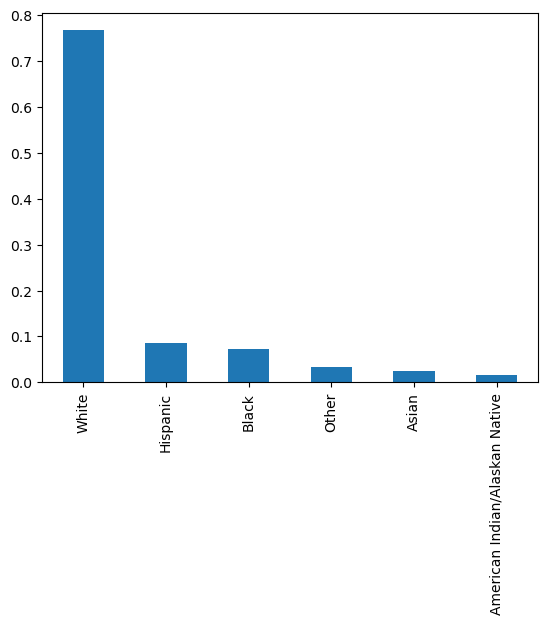

In [10]:
df_train['Race'].value_counts(normalize=True).plot(kind="bar")

*Conclusion:*

There is a **BIG** problem here, with a very unbalanced distribution. 

Removing the feature is NOT a solution here, because black people are known to have less risks regarding heart diseases than white people. If you just remove the field, you will lose information.

But you cannot keep it like that neither, because your models may have big biases for non-white people (too few data points).

Potential solutions:
* Create 2 models, one for white people, one for all other ethnicities (that are more balanced)
* Subsampling on white people
* Find more data for diversity

#### Conclusion on categorical features

**Ideal feature:**
* no missing values
* no "extra" modalities (i.e. modality that are not what you can expect)
* well-balanced distribution (or nearly balanced)

**If not ideal:**
* grab new data
* subsampling / undersampling
* oversampling
* feature engineering
* create many specific models
* choose the right metric(s)

#### For numerical features

Numerical features are, in the "perfect" cases:

* with a Gaussian distribution or a uniform one
* with no outliers
* with no "gaps" in distribution
* with no missing values.

**BMI** is used to evaluate overweight / obesity (a known risk factor).

In [11]:
# BMI description
df_train['BMI'].describe()

count    255836.000000
mean         28.328565
std           6.365487
min          12.020000
25%          24.030000
50%          27.340000
75%          31.420000
max          94.850000
Name: BMI, dtype: float64

*Note:* 

If I had a BMI of 94.85, I would weight ~258 kg / 567lbs. But world peak BMIs are around 200 (weight > 500kg/1200lbs).

In [12]:
# No missing values
df_train['BMI'].isna().sum()

0

<AxesSubplot:ylabel='Frequency'>

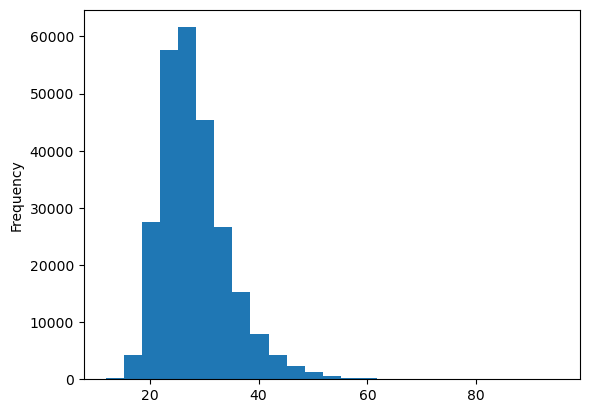

In [13]:
df_train['BMI'].plot(kind="hist", bins=25)

*Conclusion:*

BMI values are all positive, with a median of 27 (overweight).

But BMI doesn't have a Gaussian distribution but has a long tail. Very few datapoints have a very high BMI. There is a high risk of bias for obese people.

One possibility is to transform this feature in a categorical one: underweight (<18), normal (18-25), overweight (25-30), obesity (30-35), severe obesity (>35). It keeps the meaning of the field, but it will have a more balanced distribution.

Removing high values (outliers) may not be a smart move here as the model will not work a lot on people with severe obesity.

**Physical Health** is the number of sick days in the last 30 days.

In [14]:
# PhysicalHealth description
df_train['PhysicalHealth'].describe()

count    255836.000000
mean          3.373950
std           7.952554
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          30.000000
Name: PhysicalHealth, dtype: float64

<AxesSubplot:ylabel='Frequency'>

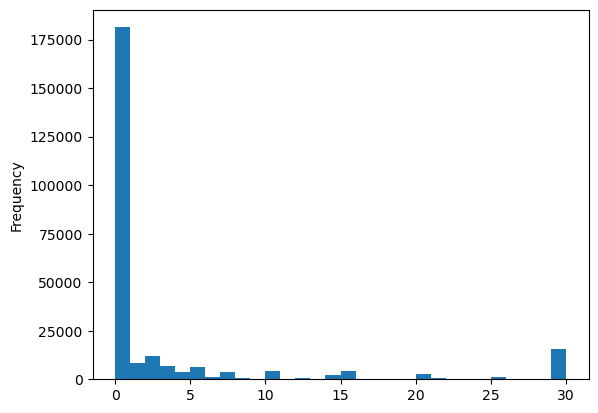

In [15]:
# Distribution
df_train['PhysicalHealth'].plot(kind="hist", bins=30)

<AxesSubplot:ylabel='Frequency'>

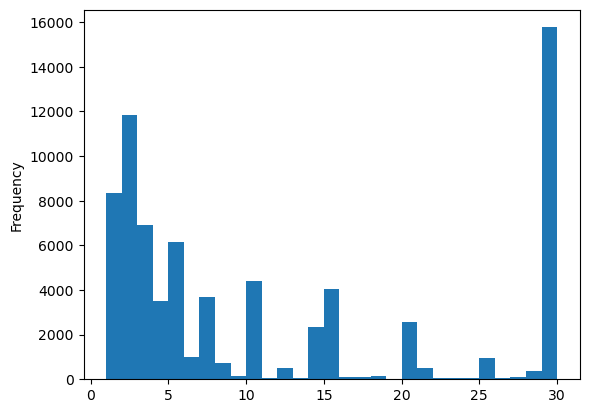

In [16]:
# Distribution for non-zero values
df_train.loc[df_train['PhysicalHealth']!=0]['PhysicalHealth'].plot(kind="hist", bins=29)

*Conclusion:*

Every value is between 0 and 30, as expected, with no missing values.

But the distribution is mainly a 0 peak. For non-zero people, the distribution is not uniform with peaks all over.

The field cannot be used, as the risk for biases are very high with decision tree-based algorithms. One solution here is to create a boolean flag: physically healthy the whole month (PhysicalHealth == 0) or not. 

**SleepTime** is the average number of sleep hours per 24h. We expect numbers between 0 and 24, with a center around 6-10h.

In [17]:
# SleepTime description
df_train['SleepTime'].describe()

count    255836.000000
mean          7.096941
std           1.435448
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          24.000000
Name: SleepTime, dtype: float64

<AxesSubplot:ylabel='Frequency'>

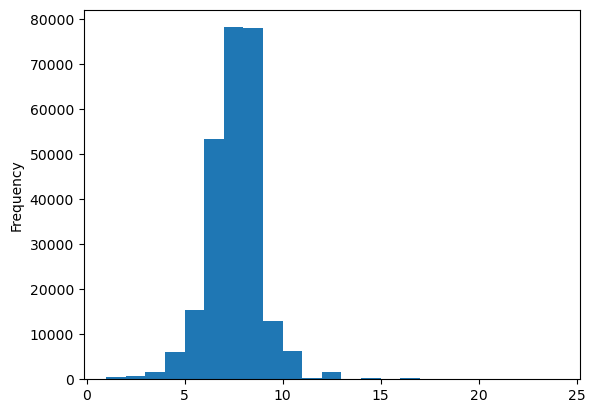

In [18]:
# Plot
df_train['SleepTime'].plot(kind="hist", bins=23)

<AxesSubplot:>

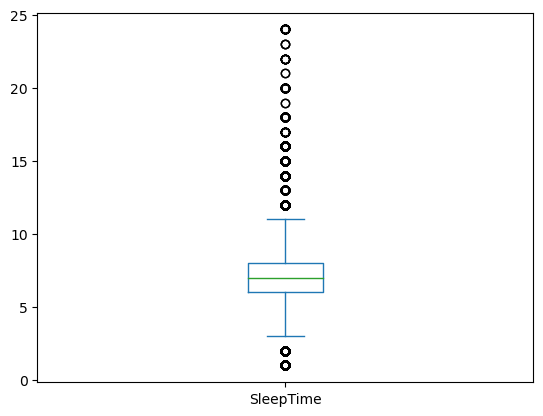

In [19]:
# Box plot
df_train['SleepTime'].plot.box()

*Conclusion:* 

SleepTime is very strange with at least one person sleeping on average 24h/day, so sleeping all day long (and so not answering the phone). 

The distribution is also a long tail, and so in this case also, it may be a good idea to keep high or low values and to create another categorical feature, for example with the following values: "too little", "not enough", "enough", "a little too much", "too much". It will be more balanced, keep the meaning, and be more easily used by training algorithms.

#### Conclusion on numerical features

**Ideal feature:**

* with a Gaussian distribution or a uniform one
* with no outliers
* with no "gaps" in distribution
* with no missing values.

**If not ideal (be careful):**
* impute missing values => big risk of bias!!
* clip => big risk of bias!!
* feature engineering (create categorical features keeping the meaning)
* create many specific models.

### Bivariate analysis

Every link between 2 variables is 
* either a bias
* or an insight.

No one can decide for you! So, you have to study them carefully.

#### Between numerical variables

You can do a correlation matrix and/or plot heatmaps or scatterplots.

In [20]:
# Correlation matrix
df_train.corr()

BMI  PhysicalHealth  MentalHealth  SleepTime
BMI             1.000000        0.110672      0.065046  -0.051812
PhysicalHealth  0.110672        1.000000      0.287615  -0.060923
MentalHealth    0.065046        0.287615      1.000000  -0.121305
SleepTime      -0.051812       -0.060923     -0.121305   1.000000

<AxesSubplot:>

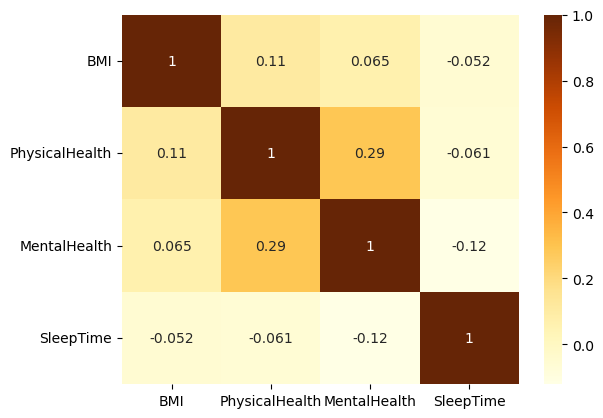

In [21]:
# Create a heatmap (visual correlation matrix)
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlOrBr")

A "high" correlation is an absolute value of ~80% and more. Here we don't really have high correlations.

However, we can see that PhysicalHealth and MentalHealth have a link. Sometimes, plotting can help to imagine if the correlation is a problem/insight or just random.

<AxesSubplot:xlabel='PhysicalHealth', ylabel='MentalHealth'>

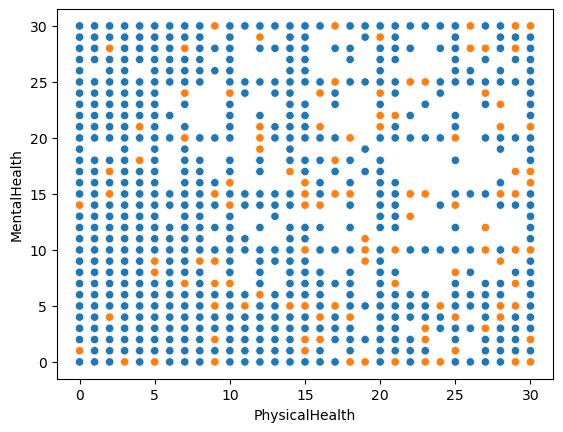

In [22]:
# Plot PhysicalHealth vs MentalHealth
sns.scatterplot(data=df_train, x='PhysicalHealth', y='MentalHealth', hue='HeartDisease', legend=False)

With integers and a lot of data, it's often very difficult to spot correlations. A tip consists of adding a small random noise, just to be able to see a bit more the dataset. We can then see some correlations/points of interest.

<AxesSubplot:xlabel='PhysicalHealth', ylabel='MentalHealth'>

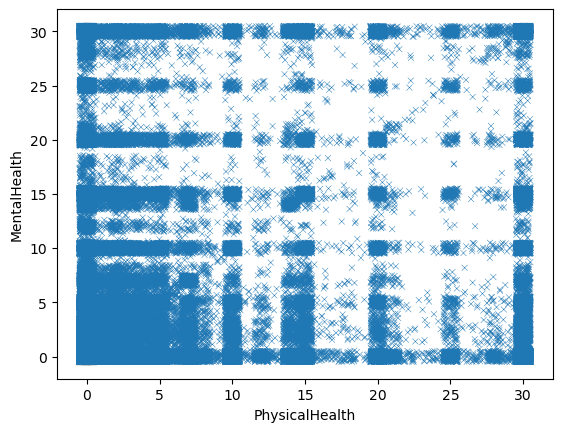

In [23]:
# Small tip: add a little random noise to better see
df_rand = df_train[['PhysicalHealth', 'MentalHealth', 'HeartDisease']].copy()
df_rand['PhysicalHealth'] = df_rand['PhysicalHealth'] + (np.random.rand(df_rand.shape[0]) - 0.5)
df_rand['MentalHealth'] = df_rand['MentalHealth'] + (np.random.rand(df_rand.shape[0]) - 0.5)
sns.scatterplot(data=df_rand, x='PhysicalHealth', y='MentalHealth', legend=False, marker='x', size=0.5)

#### Between numerical and categorical variables

You can do boxplots and/or group by statistics. The goal is to see if the distributions (of the numerical feature) is the same for every modality (of the categorical feature) or if there's a correlation between them.

Here, for example, we look at BMI and Heart Disease:

BMI    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

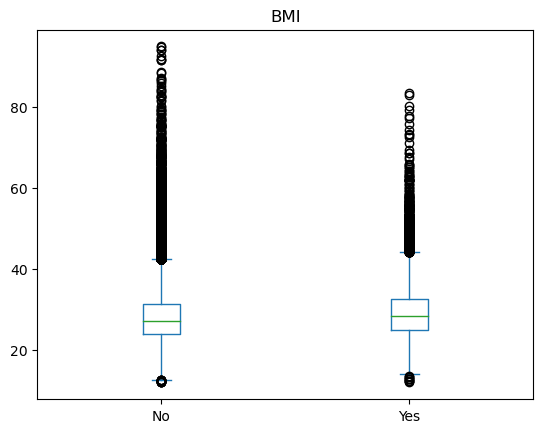

In [24]:
# Box plot
df_train.plot.box(column="BMI", by="HeartDisease")

In [25]:
# Statistics
df_train.groupby(['HeartDisease'])['BMI'].describe()

count       mean       std    min    25%    50%    75%    max
HeartDisease                                                                  
No            233923.0  28.226617  6.335643  12.02  23.89  27.26  31.32  94.85
Yes            21913.0  29.416869  6.578170  12.21  25.06  28.34  32.69  83.33

We can see that BMI is slightly less for people without Heart Disease (even if the mean is superior). It means that overweight / obesity may be a risk factor. As it's something known, it's not a bias but an insight that we must keep!

We can do the same with physical health.

PhysicalHealth    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

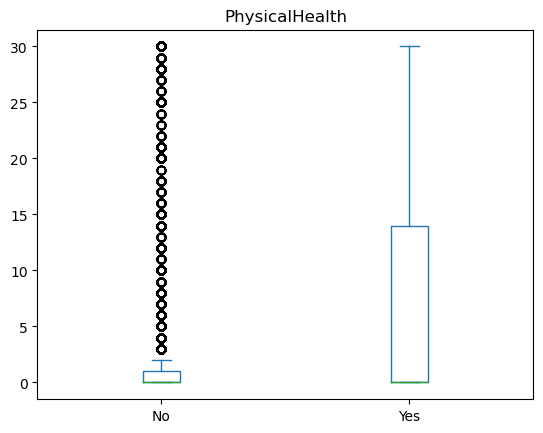

In [26]:
# Box plot
df_train.plot.box(column="PhysicalHealth", by="HeartDisease")

This time the link is even stronger: people without heart disease have a very low number of sick days in the last month, but for people with heart disease, the number is in 75% between 0 and ~15 (1/4 of them have more than 15 sick days).

Moreover, there are no outliers for heart persons.

Here too we have a big link that is only an insight, even if being sick is not a risk factor: maybe it indicates that the person has other health issues, with some same risk factors than heart diseases.

#### Between categorical variables

Even between categorical features, you can spot some correlations. You can use pivot tables (statistics) or mosaic plots (visual).

First, we are starting here with the link between Sex and HeartDisease:

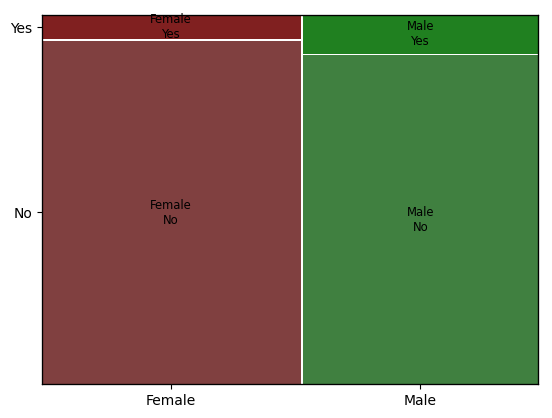

In [27]:
# Mosaic plot
mosaic(df_train, ['Sex', 'HeartDisease'])
plt.show()

In [28]:
# Pivot table
df_train.groupby('Sex')['HeartDisease'].value_counts(normalize=True)

Sex     HeartDisease
Female  No              0.933138
        Yes             0.066862
Male    No              0.893650
        Yes             0.106350
Name: HeartDisease, dtype: float64

We can see that men have more heart diseases than women. Of course it's biased against anyone not recognizing itself in the man/woman classification, but at least the link between gender and heart disease is a known one: it's another insight we have to keep.

On the contrary, we are studying alcohol drinking vs hear disease:

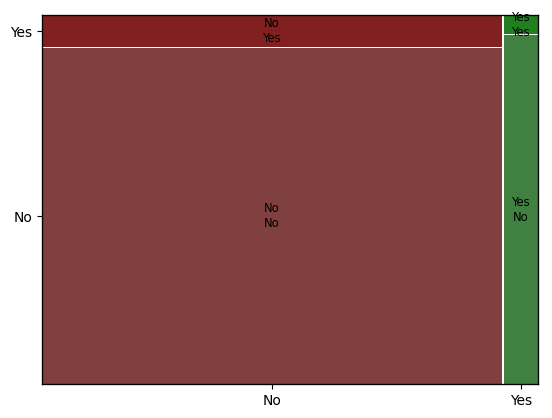

In [29]:
# Mosaic plot
mosaic(df_train, ['AlcoholDrinking', 'HeartDisease'])
plt.show()

In [30]:
# Pivot table
df_train.groupby('AlcoholDrinking')['HeartDisease'].value_counts(normalize=True)

AlcoholDrinking  HeartDisease
No               No              0.911940
                 Yes             0.088060
Yes              No              0.947326
                 Yes             0.052674
Name: HeartDisease, dtype: float64

What we can see here is that drinking a lot of alcohol nearly divide by 2 the risk to have an heart disease => data is saying that "not drinking" is a risk factor.

We know that it's in reality the contrary: alcoholics have a lot more heart diseases than non-drinking persons.

We have here a **BIG** bias, that we must mitigate, maybe removing the feature or trying to find more alcoholic persons.

(And we know that this feature is not very reliable as it was a phone survey and a lot of people will lie saying they do not drink)

### Data Understanding and biases

By analyzing all the features and then all the pairs of features, it is possible to determine whether the distributions of the variables or the correlations between them are acceptable or whether they can lead to biases, either by lack of representativeness, or by a representation contrary to reality.

This phase must be fully traced for future reference. In addition, it is important to give advice for the rest of the project, the next phase being the data preparation.

Most biases in the dataset are therefore normally detected at the end of this phase, which makes it possible to take the necessary measures so that they are not found in the models.

Of course, all this takes a long time, but it is the price to pay for fairer and more non-discriminatory models.

Subsequently, and for the sake of simplicity, none of the biases detected here will be removed. Therefore, there is a high chance that the models are biased and that the algorithms used to understand them (eXplainable AI) detect biases.

## Data Preparation

As we have said, for the sake of this demonstration, only the bare minimum will be done in the data preparation step. We will create a Scikit-Learn pipeline to transform every feature in a numerical one and split X and y features for future training.

In [31]:
# Before data preparation
df_train.head(10)

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
271884           No  27.63     Yes              No     No             0.0   
270361           No  21.95      No              No     No             0.0   
219060           No  31.32     Yes              No     No             0.0   
24010            No  40.35      No              No     No            30.0   
181930           No  35.61     Yes              No     No            30.0   
24149           Yes  24.63     Yes              No     No             0.0   
185683           No  41.73      No              No     No             0.0   
316656           No  16.30      No              No     No             2.0   
305719           No  21.52     Yes              No     No            30.0   
56786            No  29.53     Yes              No     No            28.0   

        MentalHealth DiffWalking     Sex  AgeCategory      Race Diabetic  \
271884          25.0          No  Female        25-29  Hispanic       No   
270361          20.0          No  Female        30-34     White       No   
219060           0.0          No  Female        40-44     White       No   
24010            0.0          No  Female        65-69     White       No   
181930          30.0         Yes  Female        60-64     White       No   
24149            0.0          No  Female  80 or older     White      Yes   
185683           0.0          No    Male        35-39     White       No   
316656           0.0          No  Female        25-29  Hispanic       No   
305719           0.0          No    Male        65-69     White       No   
56786           30.0         Yes    Male        45-49     Black       No   

       PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
271884              Yes  Very good        7.0     No            No         No  
270361              Yes  Excellent        6.0     No            No        Yes  
219060              Yes  Very good        6.0    Yes            No         No  
24010                No       Good        8.0     No            No         No  
181930               No       Fair        4.0    Yes            No        Yes  
24149               Yes  Very good        8.0     No            No         No  
185683              Yes  Very good        7.0     No            No         No  
316656               No  Excellent        8.0     No            No         No  
305719               No       Good        8.0     No            No         No  
56786               Yes       Fair        5.0    Yes            No         No

Using a column transformer, we will do these transformations:
* for Boolean values, we will just replace 'Yes' by 1 and 'No' by 0. For diabetes, we will put minority modalities in 'Yes' or 'No' ones.
* for ordered values (like GenHealth), we will replace each value by a number to keep the order (one-hot encoding is losing it)
* for other categorical values, we use one-hot encoding
* for physical and mental health, we will create a flag with 0/1 value (meaning "0 day" or "1+ day")
* for other numerical values, we will use a robust scaler to have the same scale for every feature.

We then create the whole pipeline.

In [32]:
# For boolean values: 0/1 encoding (and for diabetes, replacement for !(Yes/No) values)
def replacement_encoder(df):
    for col in df.columns:
        df[col].replace('Yes (during pregnancy)', 'Yes', inplace=True)
        df[col].replace('No, borderline diabetes', 'No', inplace=True)
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    return df

boolean_pipeline = Pipeline(
  steps=[
    ('replace', preprocessing.FunctionTransformer(replacement_encoder))
  ]
)

In [33]:
# For ordered features: replacement by numbers
categories = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']

ordered_pipeline = Pipeline(
  steps=[
    ('replacement', preprocessing.OrdinalEncoder(categories=[categories]))
  ]
)

In [34]:
# For categorical features: one-hot encoding
categorical_pipeline = Pipeline(
  steps=[
    ('one_hot', preprocessing.OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
  ]
)

In [35]:
# For Health: specific pipeline to flag values
health_pipeline = Pipeline(
  steps=[
    ('binarize', preprocessing.Binarizer(threshold=0))
  ]
)

In [36]:
# For numerical values: Robust Scaler
numeric_pipeline = Pipeline(
    steps=[
    ('scaler', preprocessing.RobustScaler())
  ]
)  

In [37]:
# Whole preparation pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('boolean', boolean_pipeline, ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Diabetic', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']),
        ('ordered', ordered_pipeline, ['GenHealth']),
        ('numeric', numeric_pipeline, ['BMI', 'SleepTime']),
        ('categorical', categorical_pipeline, ['Sex', 'AgeCategory', 'Race']),
        ('health', health_pipeline, ['PhysicalHealth', 'MentalHealth'])
    ]
)

preprocessor

ColumnTransformer(transformers=[('boolean',
                                 Pipeline(steps=[('replace',
                                                  FunctionTransformer(func=<function replacement_encoder at 0x7fbd1194b670>))]),
                                 ['Smoking', 'AlcoholDrinking', 'Stroke',
                                  'DiffWalking', 'Diabetic', 'PhysicalActivity',
                                  'Asthma', 'KidneyDisease', 'SkinCancer']),
                                ('ordered',
                                 Pipeline(steps=[('replacement',
                                                  OrdinalEncoder(categories=[['Poor',
                                                                              'Fair'...
                                                                              'Very '
                                                                              'good',
                                                                              '

As we will lose the columns names switching from Pandas to Scikit-Learn, we also create them (map function used for Boolean values made it impossible to get only via pipelines functions).

In [38]:
columns_names = ['boolean__Smoking_Yes', 'boolean__AlcoholDrinking_Yes',
       'boolean__Stroke_Yes', 'boolean__DiffWalking_Yes',
       'boolean__Diabetic_Yes',
       'boolean__PhysicalActivity_Yes', 'boolean__Asthma_Yes',
       'boolean__KidneyDisease_Yes', 'boolean__SkinCancer_Yes',
       'ordered__GenHealth', 'numeric__BMI', 'numeric__SleepTime',
       'categorical__Sex_Male', 'categorical__AgeCategory_18-24',
       'categorical__AgeCategory_25-29', 'categorical__AgeCategory_30-34',
       'categorical__AgeCategory_35-39', 'categorical__AgeCategory_40-44',
       'categorical__AgeCategory_45-49', 'categorical__AgeCategory_50-54',
       'categorical__AgeCategory_55-59', 'categorical__AgeCategory_60-64',
       'categorical__AgeCategory_65-69', 'categorical__AgeCategory_70-74',
       'categorical__AgeCategory_75-79',
       'categorical__AgeCategory_80 or older',
       'categorical__Race_American Indian/Alaskan Native',
       'categorical__Race_Asian', 'categorical__Race_Black',
       'categorical__Race_Hispanic', 'categorical__Race_Other',
       'categorical__Race_White', 'health__PhysicalHealth',
       'health__MentalHealth']

To finish with, we create the X (input) and y (target) features.

In [39]:
# Split train/test
y_train = df_train['HeartDisease']
X_train = df_train.drop('HeartDisease', axis=1)

y_test = df_test['HeartDisease']
X_test = df_test.drop('HeartDisease', axis=1)

## Modeling

After the study of the source (Business Understanding) and the dataset (Data Understanding), a small Data Preparation was done. We know that we have kept biases in the data.

Now, we will create 2 simple models, just to be sure that we can find biases thanks to eXplainable AI in the next phase (Evaluation).

The first model is a very simple tree we will be able to plot (max depth of 3) and the second one a bigger tree (max depth of 10). Moreover, in the second case, because we know that the target feature is very unbalanced, we have changed the class weight.

In [40]:
# Pipeline with DecisionTree models
small_tree_ppl = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])
big_tree_ppl = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(max_depth=10, random_state=42, criterion='entropy', class_weight='balanced'))])

In [41]:
# Small tree training
small_tree_ppl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('boolean',
                                                  Pipeline(steps=[('replace',
                                                                   FunctionTransformer(func=<function replacement_encoder at 0x7fbd1194b670>))]),
                                                  ['Smoking', 'AlcoholDrinking',
                                                   'Stroke', 'DiffWalking',
                                                   'Diabetic',
                                                   'PhysicalActivity', 'Asthma',
                                                   'KidneyDisease',
                                                   'SkinCancer']),
                                                 ('ordered',
                                                  Pipeline(steps=[('replacement',
                                                                   OrdinalEn...
                       

In [42]:
# Big tree training
big_tree_ppl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('boolean',
                                                  Pipeline(steps=[('replace',
                                                                   FunctionTransformer(func=<function replacement_encoder at 0x7fbd1194b670>))]),
                                                  ['Smoking', 'AlcoholDrinking',
                                                   'Stroke', 'DiffWalking',
                                                   'Diabetic',
                                                   'PhysicalActivity', 'Asthma',
                                                   'KidneyDisease',
                                                   'SkinCancer']),
                                                 ('ordered',
                                                  Pipeline(steps=[('replacement',
                                                                   OrdinalEn...
                       

Now we can test our models, starting with the small tree:

In [43]:
# Classification report on test data for the small tree
y_pred = small_tree_ppl.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.92      1.00      0.96     58499
         Yes       0.54      0.04      0.08      5460

    accuracy                           0.92     63959
   macro avg       0.73      0.52      0.52     63959
weighted avg       0.89      0.92      0.88     63959



In [44]:
# And confusion matrix
confusion_matrix(y_test, y_pred)

array([[58294,   205],
       [ 5224,   236]])

As we can see, the small tree is rather bad, even if accuracy is 92% because it mainly says that no one has heart disease. What is more important for us is the **recall for the 'Yes' class**, indicating how many risky persons we have found in the dataset. Here it's only 4%... (and with a bad precision of 1/2 so the f1-score is only 8%).

In a real case, such a model will not be analyzed further, but here we will keep it for simplicity.

We then test our big tree.

In [45]:
# Classification report
y_pred = big_tree_ppl.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.97      0.72      0.83     58499
         Yes       0.21      0.79      0.33      5460

    accuracy                           0.73     63959
   macro avg       0.59      0.75      0.58     63959
weighted avg       0.91      0.73      0.79     63959



In [46]:
# And confusion matrix
confusion_matrix(y_test, y_pred)

array([[42163, 16336],
       [ 1155,  4305]])

This model is **WAY** better, with a recall of nearly 80%, even if the accuracy dropped to 73%. Now, we are detecting high risk persons, even if the precision is very low (~20%). So, we will spot 5 more risky people than the reality, meaning other medical tests will be needed with such a model.

But as the original dataset has a bias (people are knowing they have a heart disease after it's diagnosed), maybe a part of the 80% will have heart disease in the future...

## Evaluation

Once a model is created, it's important to test it to find any bias, coming from the dataset, and not seen before, or to assure that potential biases detected are not present in the models. So, we must to find WHY specific decisions are made.

Most models are not **interpretable** (i.e.: we can understand their inner working directly by looking at it). There is also a bias between interpretability and the accuracy you can have:

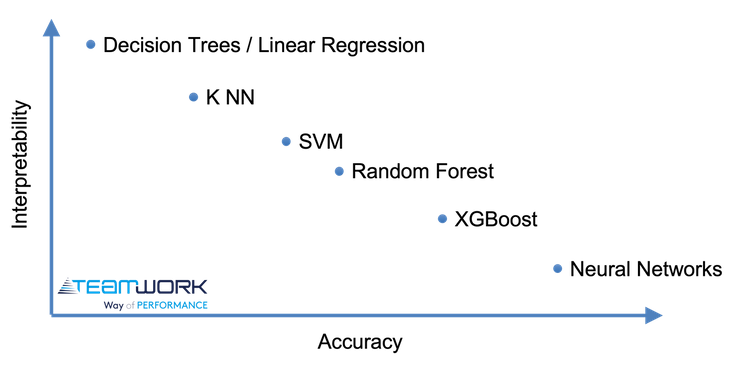

In most cases, it will be necessary to **explain** the model a posteriori.

For this, the whole branch of eXplainable AI (XAI) can be used. Several algorithms are possible, each one being able to provide different information on the tested model.

**eXplainable AI** algorithms can be seen on two axes:
* *Local/Global:* is the algorithm explaining a specific decision (for one datapoint) or for the whole dataset
* *Specific/Agnostic:* is the algorithm working on a specific learning algorithm or on all algorithms

There is a lot of XAI algorithms (non-exhaustive list):

||Local|Global|
|---|---|---|
|**Specific**|Occlusion Analysis (CNN)<br>Saliency Map (CNN)|Feature Importance (tree based)<br>Coefficients reading (linear regression)<br>Rules (rules-based)|
|**Agnostic**|LIME<br>Shap<br>Counterfactual<br>ICE (1 feature)<br>MACE|Partial Dependance Plot (PDP)<br>ALE<br>Prototypes & Criticisms<br>Sensitivity Analysis|

Every type of algorithm will give different insights on the model, so it's important to use many of them to be sure to detect most biases.

### Feature importances (specific & global), for tree-based algorithms

This algorithm will tell you which features have the most importance in the decision making process, ranking them with a percentage.

More information on this algorithm here:
https://machinelearningmastery.com/calculate-feature-importance-with-python/

#### For the small decision tree

We can directly ask to Scikit-Learn the feature importances for our small tree. We can see that only 5 features are used, all other features having a 0 importance.

Moreover, more than 50% of the decision is made on only one feature. But it's hard to understand which one just looking at the result.

In [47]:
# Feature importances for the small tree
small_tree_ppl['classifier'].feature_importances_

array([0.        , 0.        , 0.2935539 , 0.        , 0.06325933,
       0.        , 0.        , 0.        , 0.        , 0.52312637,
       0.        , 0.        , 0.01237924, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.10768116, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

We can use the features names to have a better understanding of them. 

The first factor is general health (50%), followed by having had a stroke in the past (30%), then being over 80 (10%), having diabetes, or being male (only 1%).

We find here the main risk factors known, so the model seems to be non-biased, regarding this algorithm (but do not forget that it's in fact very bad, with a very small recall).

In [48]:
# Feature importances with better visualization
df_fi = pd.DataFrame(small_tree_ppl['classifier'].feature_importances_, index=columns_names).round(3)
df_fi[df_fi[0]!=0].sort_values(by=[0], ascending=False)

0
ordered__GenHealth                    0.523
boolean__Stroke_Yes                   0.294
categorical__AgeCategory_80 or older  0.108
boolean__Diabetic_Yes                 0.063
categorical__Sex_Male                 0.012

#### And the big decision tree

We can do the same on the big tree. Of course, with a lot more nodes, there is also more features used. The first ones are still the same: general health, age, a previous stroke, and being a male.

However, we can see that 70-74 class age has a lot more importance than 60-64, 64-69 or 75-79). It may indicate a bias with a model less precise on 70-74yo.

One thing we couldn't know from the feature importances is the impact, negative or positive, on the decision.

In [49]:
# Feature importances for the big tree
df_fi = pd.DataFrame(big_tree_ppl['classifier'].feature_importances_, index=columns_names).round(3)
df_fi[df_fi[0]!=0].sort_values(by=[0], ascending=False)

0
ordered__GenHealth                    0.385
categorical__AgeCategory_80 or older  0.089
categorical__AgeCategory_70-74        0.070
boolean__Stroke_Yes                   0.069
categorical__Sex_Male                 0.058
categorical__AgeCategory_75-79        0.058
categorical__AgeCategory_65-69        0.056
categorical__AgeCategory_60-64        0.044
numeric__BMI                          0.031
categorical__AgeCategory_55-59        0.027
boolean__Diabetic_Yes                 0.021
categorical__AgeCategory_50-54        0.018
boolean__Smoking_Yes                  0.009
numeric__SleepTime                    0.008
boolean__DiffWalking_Yes              0.007
boolean__KidneyDisease_Yes            0.006
categorical__AgeCategory_18-24        0.006
categorical__Race_White               0.006
categorical__AgeCategory_35-39        0.005
categorical__AgeCategory_25-29        0.005
categorical__AgeCategory_40-44        0.004
categorical__AgeCategory_30-34        0.004
boolean__AlcoholDrinking_Yes          0.002
boolean__SkinCancer_Yes               0.002
boolean__Asthma_Yes                   0.002
categorical__Race_Black               0.002
boolean__PhysicalActivity_Yes         0.002
health__PhysicalHealth                0.002
categorical__AgeCategory_45-49        0.001
categorical__Race_Asian               0.001
categorical__Race_Other               0.001
health__MentalHealth                  0.001

### Reading the tree (specific & local), for tree-base algorithms

For trees, you can understand WHY a decision was make for a specific case just looking at the tree, if it's short enough.

Here, we want to predict if the 3rd test patient has (or not) a heart disease.

We start by printing the patient data:

In [50]:
# Test patient n°3
X_test.iloc[2]

BMI                     29.18
Smoking                    No
AlcoholDrinking            No
Stroke                     No
PhysicalHealth            1.0
MentalHealth              0.0
DiffWalking                No
Sex                    Female
AgeCategory             50-54
Race                    White
Diabetic                   No
PhysicalActivity          Yes
GenHealth           Very good
SleepTime                 6.0
Asthma                     No
KidneyDisease              No
SkinCancer                 No
Name: 15, dtype: object

Then, we can print the tree from the Scikit-Learn Classifier:

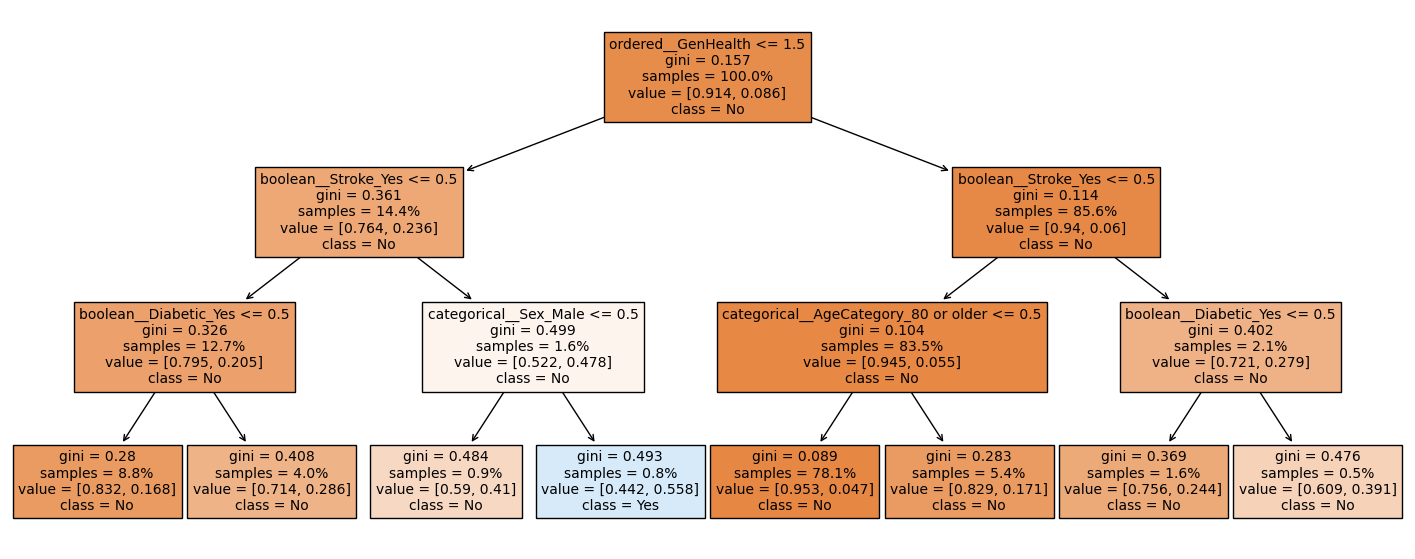

In [51]:
# Plot tree
plt.figure(figsize=(18,7))
tree.plot_tree(small_tree_ppl['classifier'], feature_names=columns_names, class_names=('No', 'Yes'), filled=True, proportion=True, fontsize=10)
plt.show()

As we can see, the tree is based on the prepared data, so we can print the prepared data for the 3rd patient:

In [52]:
# Test patient n°3 - Prepared
X_preprocessed = small_tree_ppl['preprocessor'].transform(X_test)
X_preprocessed[2]
pd.DataFrame(X_preprocessed[2], index=columns_names).round(3)

0
boolean__Smoking_Yes                              0.000
boolean__AlcoholDrinking_Yes                      0.000
boolean__Stroke_Yes                               0.000
boolean__DiffWalking_Yes                          0.000
boolean__Diabetic_Yes                             0.000
boolean__PhysicalActivity_Yes                     1.000
boolean__Asthma_Yes                               0.000
boolean__KidneyDisease_Yes                        0.000
boolean__SkinCancer_Yes                           0.000
ordered__GenHealth                                3.000
numeric__BMI                                      0.249
numeric__SleepTime                               -0.500
categorical__Sex_Male                             0.000
categorical__AgeCategory_18-24                    0.000
categorical__AgeCategory_25-29                    0.000
categorical__AgeCategory_30-34                    0.000
categorical__AgeCategory_35-39                    0.000
categorical__AgeCategory_40-44                    0.000
categorical__AgeCategory_45-49                    0.000
categorical__AgeCategory_50-54                    1.000
categorical__AgeCategory_55-59                    0.000
categorical__AgeCategory_60-64                    0.000
categorical__AgeCategory_65-69                    0.000
categorical__AgeCategory_70-74                    0.000
categorical__AgeCategory_75-79                    0.000
categorical__AgeCategory_80 or older              0.000
categorical__Race_American Indian/Alaskan Native  0.000
categorical__Race_Asian                           0.000
categorical__Race_Black                           0.000
categorical__Race_Hispanic                        0.000
categorical__Race_Other                           0.000
categorical__Race_White                           1.000
health__PhysicalHealth                            1.000
health__MentalHealth                              0.000

Now, we can just read the tree:
* GenHealth is 3 (very good) so the test is False, we go to the right
* Stroke is 0 (no stroke), so we go to the left
* Age Category is "50-54" (0 for "80 and older), we go to the left

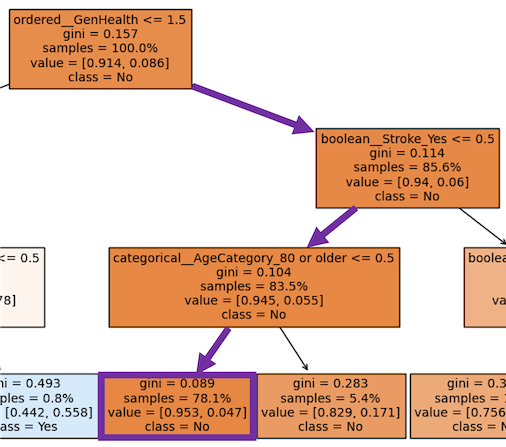

Patient will be predicted with no heart disease, with 95% confidence value. 

We can confirm that with the predict method:

In [53]:
# Predicted class
y_pred_tree = small_tree_ppl.predict(X_test)
y_pred_tree[2]

'No'

In [54]:
# Same with confidence value
y_pred_prob_tree = small_tree_ppl.predict_proba(X_test)
y_pred_prob_tree[2]

array([0.95325072, 0.04674928])

We can verify that the patient has no heart disease looking at the ground truth:

In [55]:
# Test patient n°3 - Ground truth
y_test.iloc[2]

'No'

Looking at the tree indicates which feature was used for every individual. Here we can see that one of the most important features for this tree was "Diabetic" (6%) but it's not used for this specific patient.

Therefore it's crucial to use local AND global algorithms and not only one of them, as they are complimentary and give different insights.

### LIME (Local Interpretable Model-Agnostic Explanations) (agnostic & local)

LIME is working for any model, with different explainer adapted to data types: tabular, text, image, ...

We use this implementation (with a very nice video explaining the concepts): https://github.com/marcotcr/lime

LIME is seeing our model like a black box, and so it's not based on the tree. It will take a single point, change it a little bit, and create a new dataset, with every variant of our datapoint and the output of the model. After that, it's created a "surrogate model": a new model, simpler enough to be understood (tree or linear regression). This model can then be interpreted to give insights.

First, we create here an explainer on the small tree:

In [56]:
# Explainer on small tree
explainer = LimeTabularExplainer(small_tree_ppl['preprocessor'].transform(X_train), feature_names=columns_names, class_names=['No', 'Yes'])

Then, we can ask the explaination for our 3rd patient (3 main features):

In [57]:
# Explainations for the 3rd patient
exp = explainer.explain_instance(X_preprocessed[2], small_tree_ppl['classifier'].predict_proba, num_features=3)
exp.show_in_notebook(show_table=True, show_all=False)

We have here exactly what we found reading the tree, even if the order is not the same: general health, previous stroke, and age class.

If we ask for more features (6), we will have some non-useful ones added. We know, reading the tree, that there are only 3 of them used, but due to small biases in the dataset, LIME can find more (here Diabetic, and two other age classes).

So be careful: asking too many features can add noise to the explanation.

In [58]:
# Asking too many explainations for the 3rd patient
exp = explainer.explain_instance(X_preprocessed[2], small_tree_ppl['classifier'].predict_proba, num_features=6)
exp.show_in_notebook(show_table=True, show_all=False)

We can also test it on another patient predicted in the 'Yes' class. We have the same 3 factors, and looking at the tree, only 2 on 3 are the real ones (Age is not used in the tree, but the gender is).

In [59]:
exp = explainer.explain_instance(X_preprocessed[127], small_tree_ppl['classifier'].predict_proba, num_features=3)
exp.show_in_notebook(show_table=True, show_all=False)

*Conclusion on agnostic XAI algorithms:*

Be very careful when you use an agnostic algorithm: of course, it will work on every training model, but:
* if you ask too many explanations, you will have a lot of noise, and if you ask too few, you can miss an important point
* explanations are not interpretations, so maybe the algorithm will find some features that are not really used, or miss some used ones.

In general, when you can, always prefer interpretations over explanations!

### Subpopulation Analysis (agnostic & global)

It's interesting, to find potential biases, to study the performance metrics vs one specific feature.

The goal is to find if one modality or one range of value has more errors than others.

Here, we will do that on the race. The first step is to group the test dataset by race (each group has a specific race in it):

In [60]:
# Slice on race
gb = df_test.groupby('Race')
groups = [gb.get_group(x) for x in gb.groups]
names = [x for x in gb.groups]

After that, the model (here the small tree) predicts on each group the outputs, and we create different classification reports (one by group):

In [61]:
# Subpopulation analysis for the small tree
for group, name in zip(groups, names):
    y_group = group['HeartDisease']
    X_group = group.drop('HeartDisease', axis=1)
    y_pred_group = small_tree_ppl.predict(X_group)
    print(name)
    print(classification_report(y_group, y_pred_group, zero_division=0))

American Indian/Alaskan Native
              precision    recall  f1-score   support

          No       0.90      0.99      0.95       926
         Yes       0.64      0.08      0.15       106

    accuracy                           0.90      1032
   macro avg       0.77      0.54      0.55      1032
weighted avg       0.88      0.90      0.87      1032

Asian
              precision    recall  f1-score   support

          No       0.97      1.00      0.98      1496
         Yes       0.67      0.04      0.07        52

    accuracy                           0.97      1548
   macro avg       0.82      0.52      0.53      1548
weighted avg       0.96      0.97      0.95      1548

Black
              precision    recall  f1-score   support

          No       0.93      0.99      0.96      4249
         Yes       0.38      0.05      0.09       344

    accuracy                           0.92      4593
   macro avg       0.65      0.52      0.53      4593
weighted avg       0.89      0.

We can see that the recall (the important metric) is always very low, between 4% and 8%. The model is not good for every race value in the dataset.

Nevertheless, we can see that the model detects more cases for 'American Indian/Alaskan Native' and less for 'White' and 'Asian'.

We can do the same with the big tree:

In [62]:
# Subpopulation analysis for the big tree
for group, name in zip(groups, names):
    y_group = group['HeartDisease']
    X_group = group.drop('HeartDisease', axis=1)
    y_pred_group = big_tree_ppl.predict(X_group)
    print(name)
    print(classification_report(y_group, y_pred_group))

American Indian/Alaskan Native
              precision    recall  f1-score   support

          No       0.96      0.70      0.81       926
         Yes       0.22      0.74      0.34       106

    accuracy                           0.71      1032
   macro avg       0.59      0.72      0.57      1032
weighted avg       0.88      0.71      0.76      1032

Asian
              precision    recall  f1-score   support

          No       0.98      0.86      0.92      1496
         Yes       0.13      0.58      0.21        52

    accuracy                           0.86      1548
   macro avg       0.56      0.72      0.57      1548
weighted avg       0.95      0.86      0.90      1548

Black
              precision    recall  f1-score   support

          No       0.97      0.71      0.82      4249
         Yes       0.17      0.74      0.28       344

    accuracy                           0.71      4593
   macro avg       0.57      0.72      0.55      4593
weighted avg       0.91      0.

Here we can see better results with recall between 58% and 81% but we can also see a **big racial bias**: model is better for white people (81%) and worst for Asian people (58%). The difference is too big to think it's not a real bias.

We had said, during data understanding, that having too few samples for minorities was at high risk to have bias and it's exactly what we can see here! It's why it's so important to study the data carefully and cleanse them before training!

# Conclusion / Wrap-up

There are 3 steps where you can find biases: business understanding, data understanding and evaluation.

## During Business Understanding
    
1) Even before looking at the dataset values, think about how it was made and where the data come from

2) Think about every feature: is it useful? which confidence you can have? And are there some important missing features?

## During Data Understanding

Study each feature individually:
* categorical features: try to have uniform distributions, without missing values
* numerical features: try to have uniform or Gaussian distribution

If it's, not the case, during Data Preparation, you can use subsampling, oversampling, feature engineering (creating another feature from this one), filtering (limiting rows or deleting features), asking for different models...

After that, you can study 2 features together:
* 2 categorical: use pivot table and mosaic plot
* 2 numerical: compute correlation matrix and use scatterplots
* numerical and categorical: use box plots and statistics on groups

If you find a link between 2 features, you will have to think about it: is it an interesting insight (to keep) or a bias (to delete)?

No tool can give you the answer, but some tools are able to spot correlations.

## During Evaluation

Once the dataset is ready, with no known bias, you can create your model. You will have to study them to be sure there are no new biases coming from the training process.

You can use interpretations or explanations (thanks to XAI algorithms). These algorithms may be:
* local or global, depending on the number of data points explained
* specific or agnostic, depending on the algorithm used.

Most of the time, if you want to really understand your model, use local and global algorithms, and prefer specific to model-agnostic algorithms. You will need to cross the results between different algorithms to be sure to have the best knowledge on your model, as no algorithm is perfect.

And after that, go to prod! 🚀